# Use case: Computational magnetism (Ubermag)

This notebook provides a solution to Standard Problem 3 [1] using Ubermag. Cells 6 and 7 of this notebook, together with their outputs, are shown in Figure 3 in:

- M. Beg, J. Taka, T. Kluyver, A. Konovalov, M. Ragan-Kelley, N. Thiéry, and H. Fangohr. Using Jupyter for reproducible scientific workflows. [*Computing in Science & Engineering* **23**, 36](https://ieeexplore.ieee.org/document/9325550/) (2021).

## Problem specification

The problem is to calculate a single domain limit of a cubic magnetic particle. This is the size $L$ of equal energy for the so-called flower state (which one may also call a splayed state or a modified single-domain state) on the one hand, and the vortex or curling state on the other hand.

**Geometry**:

A cube with edge length, $L$, expressed in units of the intrinsic length scale, $l_\text{ex} = \sqrt{A/K_\text{m}}$, where $K_\text{m}$ is a magnetostatic energy density, $K_\text{m} = \frac{1}{2}\mu_{0}M_\text{s}^{2}$.

Material parameters: 

- uniaxial anisotropy $K_\text{u}$ with $K_\text{u} = 0.1 K_\text{m}$, and with the easy axis directed parallel to a principal axis of the cube $(0, 0, 1)$,
- exchange energy constant is $A = \frac{1}{2}\mu_{0}M_\text{s}^{2}l_\text{ex}^{2}$.

More details about the standard problem 3 can be found in Ref. 1.

## Simulation

Firstly, we import all necessary modules.

In [1]:
%config InlineBackend.figure_formats = ['svg']  # output matplotlib plots as SVG
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc

ImportError: dlopen(/Users/marijanbeg/miniconda3/envs/paper/lib/python3.9/site-packages/vtkmodules/vtkIOFFMPEG.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/libopenh264.5.dylib
  Referenced from: /Users/marijanbeg/miniconda3/envs/paper/lib/libavcodec.58.54.100.dylib
  Reason: tried: '/Users/marijanbeg/miniconda3/envs/paper/lib/libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/lib/libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/lib/libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/lib/libopenh264.5.dylib' (no such file), '/private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-8efmfw2c/vtk_1646116189818/work/build/lib/libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/lib/libopenh264.5.dylib' (no such file), '/private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-8efmfw2c/vtk_1646116189818/work/build/lib/libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/lib/python3.9/site-packages/vtkmodules/../../../libopenh264.5.dylib' (no such file), '/private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-8efmfw2c/vtk_1646116189818/work/build/lib/libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/lib/python3.9/site-packages/vtkmodules/../../../libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/lib/libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/bin/../lib/libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/lib/libopenh264.5.dylib' (no such file), '/Users/marijanbeg/miniconda3/envs/paper/bin/../lib/libopenh264.5.dylib' (no such file), '/usr/local/lib/libopenh264.5.dylib' (no such file), '/usr/lib/libopenh264.5.dylib' (no such file)

The following two functions are used for initialising the system's magnetisation [1].

In [ ]:
import numpy as np

# Function for initiaising the flower state.
def m_init_flower(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    mx = 0
    my = 2*z - 1
    mz = -2*y + 1
    norm_squared = mx**2 + my**2 + mz**2
    if norm_squared <= 0.05:
        return (1, 0, 0)
    else:
        return (mx, my, mz)

# Function for initialising the vortex state.
def m_init_vortex(pos):
    x, y, z = pos[0]/1e-9, pos[1]/1e-9, pos[2]/1e-9
    mx = 0
    my = np.sin(np.pi/2 * (x-0.5))
    mz = np.cos(np.pi/2 * (x-0.5))
    
    return (mx, my, mz)

The following function is used for convenience. It takes two arguments:

- $L$ - the cube edge length in units of $l_\text{ex}$, and
- the function for initialising the system's magnetisation.

It returns the relaxed system object.

In [ ]:
def minimise_system_energy(L, m_init):
    print("L={:7}, {} ".format(L, m_init.__name__), end="")
    N = 16  # discretisation in one dimension
    cubesize = 100e-9  # cube edge length (m)
    cellsize = cubesize/N  # discretisation in all three dimensions.
    lex = cubesize/L  # extract exchange length from the cube edge length L.
    
    Km = 1e6  # magnetostatic energy density (J/m**3)
    Ms = np.sqrt(2*Km/mm.consts.mu0)  # magnetisation saturation (A/m)
    A = 0.5 * mm.consts.mu0 * Ms**2 * lex**2  # exchange energy constant
    K = 0.1*Km  # Uniaxial anisotropy constant
    u = (0, 0, 1)  # Uniaxial anisotropy easy-axis

    p1 = (0, 0, 0)  # Minimum sample coordinate.
    p2 = (cubesize, cubesize, cubesize)  # Maximum sample coordinate.
    cell = (cellsize, cellsize, cellsize)  # Discretisation.
    mesh = df.Mesh(p1=(0, 0, 0), p2=(cubesize, cubesize, cubesize),
                   cell=(cellsize, cellsize, cellsize))  # Create a mesh object.

    system = mm.System(name='stdprob3')
    system.energy = mm.Exchange(A=A) + mm.UniaxialAnisotropy(K=K, u=u) + mm.Demag()
    system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

    md = mc.MinDriver()
    md.drive(system, overwrite=True)
    
    return system

### Relaxed magnetisation states

Now, we show the magnetisation configurations of two relaxed states.

**Vortex** state:

In [ ]:
system = minimise_system_energy(8, m_init_vortex)
system.m.plane('y').mpl(figsize=(5, 5))

**Flower** state:

In [ ]:
system = minimise_system_energy(8, m_init_flower)
system.m.plane('y').mpl(figsize=(5, 5))

### Energy crossing

We can plot the energies of both vortex and flower states as a function of cube edge length $L$. This will give us an idea where the state transition occurrs. We can achieve that by simply looping over the edge lengths $L$ of interest, computing the energy of both vortex and flower states, and finally, plotting the energy dependence.

L=    8.0, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (2.3 s)
L=    8.0, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.2 s)
L=   8.25, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.9 s)
L=   8.25, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.2 s)
L=    8.5, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.8 s)
L=    8.5, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.2 s)
L=   8.75, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.6 s)
L=   8.75, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.2 s)
L=    9.0, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.6 s)
L=    9.0, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.1 s)


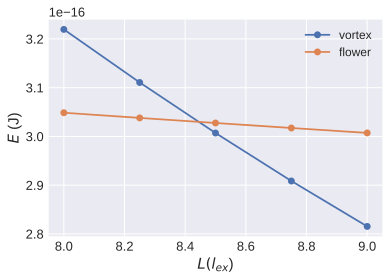

In [6]:
L_array = np.linspace(8, 9, 5)
vortex_energies, flower_energies = [], []

for L in L_array:
    vortex = minimise_system_energy(L, m_init_vortex)
    flower = minimise_system_energy(L, m_init_flower)
    vortex_energies.append(vortex.table.data.tail(1)['E'][0])
    flower_energies.append(flower.table.data.tail(1)['E'][0])

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(L_array, vortex_energies, 'o-', label='vortex')
plt.plot(L_array, flower_energies, 'o-', label='flower')
plt.xlabel(r'$L (l_{ex}$)')
plt.ylabel(r'$E$ (J)')
plt.grid()
plt.legend();

From the plot, we can see that the energy crossing occurrs between $8.4l_\text{ex}$ and $8.6l_\text{ex}$, so we can employ a root-finding (e.g. bisection) algorithm to find the exact crossing.

In [7]:
from scipy.optimize import bisect

def energy_difference(L):
    vortex = minimise_system_energy(L, m_init_vortex)
    flower = minimise_system_energy(L, m_init_flower)
    return (vortex.table.data.tail(1)['E'][0] - flower.table.data.tail(1)['E'][0])

cross_section = bisect(energy_difference, 8.4, 8.6, xtol=0.02)

print(f'\nThe energy crossing occurs at L = {cross_section}*lex')

L=    8.4, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.8 s)
L=    8.4, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.2 s)
L=    8.6, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.6 s)
L=    8.6, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.2 s)
L=    8.5, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.8 s)
L=    8.5, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.2 s)
L=   8.45, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.7 s)
L=   8.45, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.2 s)
L=  8.425, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.8 s)
L=  8.425, m_init_flower Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.2 s)
L= 8.4375, m_init_vortex Running OOMMF (ExeOOMMFRunner) [2020/12/21 17:33]... (1.7 s)
L= 8.4375, m_init_flower Running OOMMF (ExeOOMMFRunner

## References

[1] µMAG Site Directory http://www.ctcms.nist.gov/~rdm/mumag.org.html